In [2]:
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as F
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist
import matplotlib.ticker as mticker

In [3]:
load_dotenv()

spark = SparkSession \
    .builder \
    .master('spark://localhost:7077') \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.1") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
     .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
     .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
     .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
     .config("spark.hadoop.google.cloud.auth.type", "SERVICE_ACCOUNT_JSON_KEYFILE") \
     .config("spark.hadoop.fs.gs.project.id", os.getenv('PROJECT_ID')) \
     .appName("participants_survey") \
     .getOrCreate()

:: loading settings :: url = jar:file:/home/Bagas/spark/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/Bagas/.ivy2/cache
The jars for the packages stored in: /home/Bagas/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-15981aeb-3f27-4428-88d9-d610fde5a6ba;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 in central
:: resolution report :: resolve 153ms :: artifacts dl 3ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-------------------------------------------------------------------

In [4]:
spark

## Load and Set Schema 

In [5]:
# Load Data
base_dir = "gs://project-abd/raw/"
participant_info_dir = os.path.join(base_dir, "participant_class_info/")
survey_dir = os.path.join(base_dir, "survey/")

try:
    df_student = spark.read.csv(os.path.join(participant_info_dir, "student.csv"),
                                header=True,
                                inferSchema=True)
    df_class = spark.read.csv(os.path.join(participant_info_dir, "class_table.csv"),
                                header=True,
                                inferSchema=True)
    df_survey = spark.read.csv(os.path.join(survey_dir, "student_survey.csv"),
                                header=True,
                                inferSchema=True)
except Exception as e:
    print(f'Error reading data from GCS : {e}')

In [ ]:
# Schema for student_info dataset
student_info_schema = types.StructType([
     types.StructField('Pid', types.IntegerType(), True),
     types.StructField('Gender', types.StringType(), True),
     types.StructField('Age', types.IntegerType(), True),
     types.StructField('Form Room', types.StringType(), True),
     types.StructField('Math Room', types.StringType(), True),
     types.StructField('Language Room', types.StringType(), True),
     types.StructField('What is your general feeling in the classroom? - 1', types.IntegerType(), True),
     types.StructField("When I am engaged in class: - I usually don't feel too hot or too cold.", types.StringType(), True),
     types.StructField('When I am engaged in class: - I could get distracted when the room is too hot or too cold.', types.StringType(), True),
 ])
for field in student_info_schema.fields:
     df_student = df_student.withColumn(field.name, F.col(f"`{field.name}`").cast(field.dataType))

df_student = df_student.withColumnRenamed("What is your general feeling in the classroom? - 1", "General Feeling in Classroom")
df_student = df_student.withColumnRenamed("When I am engaged in class: - I usually don't feel too hot or too cold.", "I usually don't feel too hot or cold in class (Engaged)")
df_student = df_student.withColumnRenamed("When I am engaged in class: - I could get distracted when the room is too hot or too cold.", "Distracted by Temperature (Engaged)")

In [14]:
# Schema for class_table dataset
class_schema = types.StructType([
     types.StructField('Class_id', types.IntegerType(), True),
     types.StructField('Room', types.StringType(), True),
     types.StructField('Start_time', types.TimestampType(), True),
     types.StructField('Finish_time', types.TimestampType(), True),
     types.StructField('Class_len', types.StringType(), True),
     types.StructField('Week', types.IntegerType(), True),
     types.StructField('Weekday', types.IntegerType(), True),
     types.StructField("Class_no", types.IntegerType(), True),
     types.StructField('Subject', types.StringType(), True),
     types.StructField('is_Form', types.StringType(), True),
 ])
for field in class_schema.fields:
     df_class = df_class.withColumn(field.name, F.col(f"`{field.name}`").cast(field.dataType))


In [19]:
# Schema for student_survey dataset
survey_schema = types.StructType([
     types.StructField('Pid', types.IntegerType(), True),
     types.StructField('Week', types.IntegerType(), True),
     types.StructField('Weekday', types.IntegerType(), True),
     types.StructField('Time', types.TimestampType(), True),
     types.StructField('Thermal_sensation', types.IntegerType(), True),
     types.StructField('Thermal_preference', types.StringType(), True),
     types.StructField('Clothing', types.StringType(), True),
     types.StructField("Loc_x", types.IntegerType(), True),
     types.StructField('Loc_y', types.IntegerType(), True),
     types.StructField('Engage_1', types.StringType(), True),
     types.StructField('Engage_2', types.StringType(), True),
     types.StructField('Engage_3', types.StringType(), True),
     types.StructField('Engage_4', types.StringType(), True),
     types.StructField('Engage_5', types.StringType(), True),
     types.StructField('Arousal', types.IntegerType(), True),
     types.StructField('Valence', types.IntegerType(), True),
     types.StructField('Confidence_level', types.IntegerType(), True),
 ])
for field in survey_schema.fields:
     df_survey = df_survey.withColumn(field.name, F.col(f"`{field.name}`").cast(field.dataType))

## EDA for Student Info Dataset

In [9]:
#Check Student Info Total Data
print('Student Info Total Data')
df_student.count()

Student Info Total Data


23

In [20]:
null_value = df_student.select([F.sum(F.col(cols).isNull().cast('int')).alias(cols) for cols in df_student.columns])
null_value.show()

AnalysisException: Syntax error in attribute name: When I am engaged in class: - I usually don't feel too hot or too cold..

In [ ]:
# Student Info Basic Information
print('Student Info Dataset Schema')
df_student.printSchema()
print('\n Dataset Sample')
df_student.show(5)

Student Info Dataset Schema
root
 |-- Pid: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Form Room: string (nullable = true)
 |-- Math Room: string (nullable = true)
 |-- Language Room: string (nullable = true)
 |-- What is your general feeling in the classroom? - 1: integer (nullable = true)
 |-- When I am engaged in class: - I usually don't feel too hot or too cold.: string (nullable = true)
 |-- When I am engaged in class: - I could get distracted when the room is too hot or too cold.: string (nullable = true)


 Dataset Sample


+---+------+---+---------+---------+-------------+--------------------------------------------------+-----------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|Pid|Gender|Age|Form Room|Math Room|Language Room|What is your general feeling in the classroom? - 1|When I am engaged in class: - I usually don't feel too hot or too cold.|When I am engaged in class: - I could get distracted when the room is too hot or too cold.|
+---+------+---+---------+---------+-------------+--------------------------------------------------+-----------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|  1|Female| 16|       R3|       R3|           R1|                                                 0|                                                      Somewhat disagree|                                

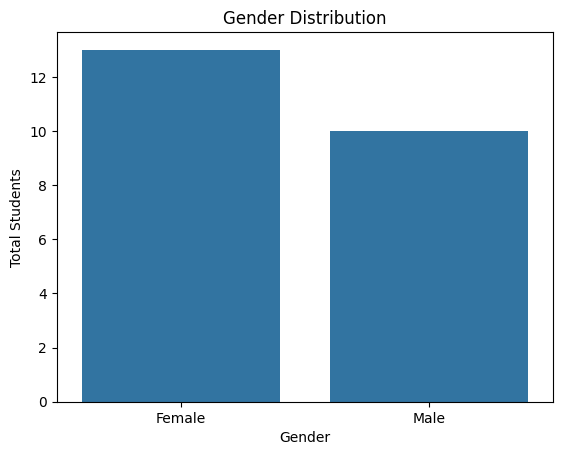

In [ ]:
# Gender Distribution 
gender_pd = df_student.select(["Pid", "Gender"]).toPandas()
count_gender = gender_pd.groupby("Gender")['Pid'].nunique().reset_index()
count_gender.columns = ["Gender", "TotalPid"]

sns.barplot(data=count_gender, x='Gender', y='TotalPid')
plt.title("Gender Distribution")
plt.ylabel("Total Students")
plt.xlabel("Gender")
plt.show()

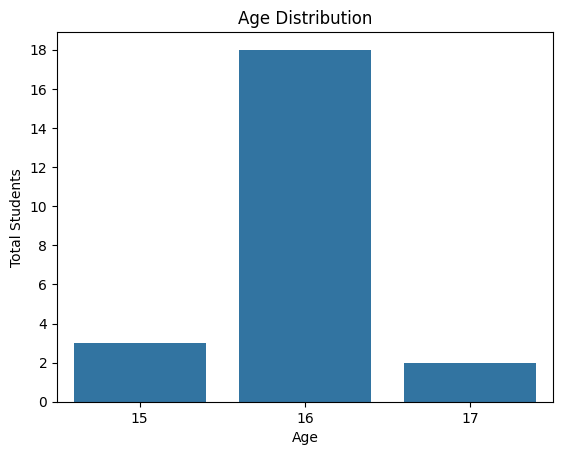

In [ ]:
# Age Distribution 
Age_pd = df_student.select(["Pid", "Age"]).toPandas()
count_Age = Age_pd.groupby("Age")['Pid'].nunique().reset_index()
count_Age.columns = ["Age", "TotalPid"]

sns.barplot(data=count_Age, x='Age', y='TotalPid')
plt.title("Age Distribution")
plt.ylabel("Total Students")
plt.xlabel("Age")
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.show()

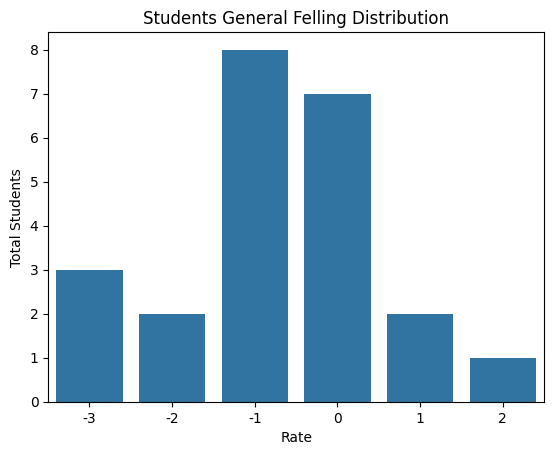

In [ ]:
# Students General Feeling in Classrooms
feeling_pd = df_student.select("What is your general feeling in the classroom? - 1").toPandas()

sns.countplot(data=feeling_pd, x='What is your general feeling in the classroom? - 1')
plt.title("Students General Felling Distribution")
plt.ylabel("Total Students")
plt.xlabel("Rate")
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.show()

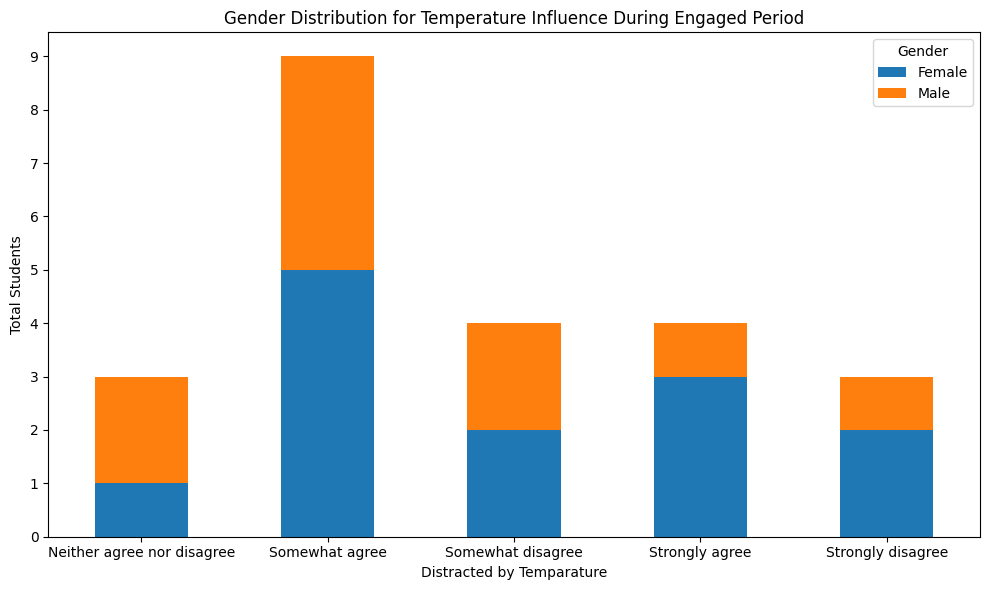

25/05/28 07:08:34 ERROR TaskSchedulerImpl: Lost executor 2 on 172.18.0.4: worker lost: 172.18.0.4:42301 got disassociated
25/05/28 07:08:34 ERROR TaskSchedulerImpl: Lost executor 0 on 172.18.0.5: worker lost: 172.18.0.5:38867 got disassociated
25/05/28 07:08:34 ERROR TaskSchedulerImpl: Lost executor 1 on 172.18.0.6: worker lost: 172.18.0.6:36619 got disassociated
25/05/28 07:08:34 WARN TransportChannelHandler: Exception in connection from /172.18.0.4:55656
java.io.IOException: Connection reset by peer
	at java.base/sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:358)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBu

In [ ]:
# Gender Distrubution for Temperatrue Influence during Engaged Period
df_temperature = df_student.groupBy("Gender") \
    .pivot("Distracted by Temparature") \
    .count() 
    
temperature_pd = df_temperature.toPandas()
temperature_stacked = temperature_pd.set_index("Gender").T
temperature_stacked.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Gender Distribution for Temperature Influence During Engaged Period")
plt.ylabel("Total Students")
plt.xlabel("Distracted by Temparature")
plt.xticks(rotation=360)
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

## EDA for Class Table Dataset

In [11]:
# Check Class Table Total Data
print('Class Table Total Data')
df_class.count()

Class Table Total Data


248

In [ ]:
# Class Info Basic Information
print('\nClass Info Dataset Schema')
df_class.printSchema()
print('\n Dataset Sample')
df_class.show(5)


Class Info Dataset Schema
root
 |-- Class_id: integer (nullable = true)
 |-- Room: string (nullable = true)
 |-- Start_time: timestamp (nullable = true)
 |-- Finish_time: timestamp (nullable = true)
 |-- Class_len: string (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- Class_no: integer (nullable = true)
 |-- Subject: string (nullable = true)
 |-- is_Form: string (nullable = true)


 Dataset Sample


+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|Class_id|Room|         Start_time|        Finish_time|Class_len|Week|Weekday|Class_no| Subject|is_Form|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
|       1|  R6|2025-05-28 09:00:00|2025-05-28 09:40:00|    short|   1|      1|       1|Assembly|    all|
|       2|  R3|2025-05-28 09:40:00|2025-05-28 11:00:00|     long|   1|      1|       2|Language|      0|
|       3|  R3|2025-05-28 11:25:00|2025-05-28 12:05:00|    short|   1|      1|       3|    Form|     R3|
|       4|  R3|2025-05-28 12:05:00|2025-05-28 13:25:00|     long|   1|      1|       4|   Maths|      0|
|       5|  R3|2025-05-28 14:15:00|2025-05-28 15:35:00|     long|   1|      1|       5| English|     R3|
+--------+----+-------------------+-------------------+---------+----+-------+--------+--------+-------+
only showing top 5 rows



## EDA for Student Survey Dataset

In [16]:
# Check Survey Total Data
print('Survey Total Data')
df_survey.count()

Survey Total Data


488

In [17]:
# Survey Basic Information
print('Student Survey Dataset Schema')
df_survey.printSchema()
print('\n Dataset Sample')
df_survey.show(5)

Student Survey Dataset Schema
root
 |-- Pid: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Thermal_sensation: integer (nullable = true)
 |-- Thermal_preference: string (nullable = true)
 |-- Clothing: string (nullable = true)
 |-- Loc_x: integer (nullable = true)
 |-- Loc_y: integer (nullable = true)
 |-- Engage_1: string (nullable = true)
 |-- Engage_2: string (nullable = true)
 |-- Engage_3: string (nullable = true)
 |-- Engage_4: string (nullable = true)
 |-- Engage_5: string (nullable = true)
 |-- Arousal: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Confidence_level: integer (nullable = true)


 Dataset Sample


+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|Pid|Week|Weekday|               Time|Thermal_sensation|Thermal_preference|            Clothing|Loc_x|Loc_y|         Engage_1|            Engage_2|            Engage_3|            Engage_4|            Engage_5|Arousal|Valence|Confidence_level|
+---+----+-------+-------------------+-----------------+------------------+--------------------+-----+-----+-----------------+--------------------+--------------------+--------------------+--------------------+-------+-------+----------------+
|  8|   1|      1|2025-05-28 10:02:00|                1|         No change|Shirt,Jumper,Pant...|  228|  112|Somewhat disagree|      Somewhat agree|      Somewhat agree|Neither agree nor...|      Somewhat agree|   NULL|   NULL|            NULL|
| 18|   1|      1|2025-0